In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from dataset import *
from vnet import *
from training import *
from niiutility import *
from loss import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, sampler, SubsetRandomSampler
from torchvision import transforms, utils

import torch.nn.functional as F  # useful stateless functions
import torchvision.transforms as T

#------------------------------- GLOBAL VARIABLES -------------------------------------#

USE_GPU = True
BATCH_SIZE = 1
NUM_WORKERS = 8
NUM_TRAIN = 259
LEARNING_RATE = 1e-2

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    
    # Some Magical Flags
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    
    print('using GPU for training')
else:
    device = torch.device('cpu')

using GPU for training


In [4]:
regen = False

if regen:
    data_index = np.arange(370)
    data_idnex = np.stack ([np.random.shuffle(data_index[:259]),np.random.shuffle(data_index[259:])])
    print(list(data_index))
else:
    data_index = np.array ([120, 148, 24, 124, 200, 76, 159, 186, 125, 164, 251, 155, 0, 252, 238, 103, 53, 179, 244, 149, 45, 31, 131, 115, 82, 216, 130, 213, 245, 199, 229, 254, 56, 158, 32, 86, 221, 84, 81, 196, 117, 38, 28, 218, 257, 7, 237, 181, 105, 194, 16, 104, 75, 78, 249, 87, 144, 1, 183, 203, 54, 255, 129, 253, 202, 25, 34, 132, 80, 89, 137, 201, 114, 189, 110, 4, 71, 195, 97, 33, 157, 21, 250,
                            192, 258, 49, 47, 119, 191, 217, 143, 68, 190, 11, 176, 206, 108, 226, 50, 69, 118, 61, 35, 57, 243, 154, 15, 102, 146, 174, 163, 156, 233, 37, 180, 100, 184, 55, 239, 135, 151, 101, 205, 220, 169, 134, 228, 234, 51, 145, 29, 207, 141, 142, 44, 175, 12, 198, 52, 8, 30, 17, 10, 2, 126, 256, 40, 85, 46, 139, 178, 235, 23, 70, 188, 209, 93, 5, 153, 172, 127, 64, 241, 182, 18, 236, 187, 79, 210, 96,
                            3, 99, 63, 123, 171, 48, 6, 165, 43, 9, 230, 211, 19, 242, 162, 161, 173, 73, 106, 59, 136, 90, 112, 167, 246, 227, 109, 225, 41, 160, 133, 22, 177, 168, 14, 152, 107, 122, 223, 74, 62, 185, 222, 13, 150, 42, 212, 248, 147, 128, 67, 83, 214, 94, 98, 219, 232, 58, 247, 88, 66, 140, 116, 92, 113, 215, 27, 60, 138, 231, 39, 72, 166, 170, 91, 77, 224, 208, 240, 95, 26, 204, 197, 121, 36, 111, 193,
                            65, 20, 324, 330, 325, 262, 351, 366, 269, 365, 369, 297, 316, 363, 293, 267, 302, 313, 352, 307, 335, 290, 356, 286, 328, 320, 340, 333, 322, 355, 315, 296, 299, 312, 341, 261, 306, 282, 283, 292, 298, 321, 346, 310, 361, 265, 314, 331, 358, 305, 349, 276, 285, 368, 271, 317, 367, 336, 279, 275, 323, 277, 281, 337, 309, 260, 357, 266, 278, 294, 319, 332, 273, 303, 280, 284, 304, 334, 360, 300, 353, 308, 345, 364, 311, 270, 362, 339, 289, 342, 348, 263, 287, 274, 295, 327, 268, 272, 318, 354, 259, 329, 350, 359, 344, 338, 343, 288, 291, 347, 264, 326, 301])

# I double checked SubsetRandomSampler and find that the data_index is sort of useless here

dataset_trans = DatasetBVSegmentation(data_index,
                         transform=transforms.Compose([
                         ])
                     )

#-------------------------CREATE DATA LOADER FOR TRAIN AND VAL------------------------#

data_size = len(dataset_trans)
train_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE, \
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)),\
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE,
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,data_size)),\
                    num_workers=NUM_WORKERS)

In [ ]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), \
          sample_batched['label'].size())
    show_batch_image(sample_batched['image'],BATCH_SIZE,None)
    print(sample_batched['label'])

    # observe 4th batch and stop.
    if i_batch == 3:
        break

In [5]:
#-------------------------Locading Localization Network-------------------------------#

LocPATH  = 'checkpoint2019-05-01 09:49:28.653642.pth'
Locmodel = LNet(img_size=(128, 128, 128), out_size=6)

if os.path.isfile(LocPATH):
    print("loading checkpoint '{}'".format(LocPATH))
    checkpoint = torch.load(LocPATH, map_location=torch.device('cpu'))
    Locmodel.load_state_dict(checkpoint['state_dict'])
    print("loaded checkpoint '{}' (epoch {})"
        .format(LocPATH, checkpoint['epoch']))
    
Locmodel = Locmodel.to(device=device)

loading checkpoint 'checkpoint2019-05-01 09:49:28.653642.pth'
loaded checkpoint 'checkpoint2019-05-01 09:49:28.653642.pth' (epoch 1051)


In [6]:

#-------------------------Locading Segmentation Network-------------------------------#

SegPATH = 'checkpoint2019-05-11 19:09:57.117475.pth'
# SegPATH = 'checkpoint2019-05-13 09:27:46.777908.pth'
Segmodel = VNet(classnum=1, slim=True)

if os.path.isfile(SegPATH):
    print("loading checkpoint '{}'".format(SegPATH))
    checkpoint = torch.load(SegPATH, map_location=torch.device('cpu'))
    Segmodel.load_state_dict(checkpoint['state_dict'])
    print("loaded checkpoint '{}' (epoch {})"
        .format(SegPATH, checkpoint['epoch']))
    
Segmodel = Segmodel.to(device=device)

loading checkpoint 'checkpoint2019-05-11 19:09:57.117475.pth'
loaded checkpoint 'checkpoint2019-05-11 19:09:57.117475.pth' (epoch 401)


In [7]:
def check_seg(Locmodel, Segmodel, dataloader, device, dtype, nstd):
    Locmodel.eval()
    Segmodel.eval()  # set model to evaluation mode
    with torch.no_grad():
        DSC = 0
        N = len(dataloader)
        DSCarray = []
        for t, batch in tqdm(enumerate(dataloader)):
            x = batch['image']
            y = batch['label']
            xhalf = batch['half']
            x = x.numpy()  
            y = y.numpy()
            xhalf = xhalf.to(device=device, dtype=dtype)

            # Getting the bbox from region proposal network
            batchSize = BATCH_SIZE

            xslice = np.zeros(xhalf.shape) - 64 #same mean removal
            yslice = np.zeros(xhalf.shape) # generate ground truth mask
            
            ###
            
            loc = Locmodel(xhalf)

            yhat = loc.cpu().numpy()
                        
            xcenter = np.mean(yhat[:,0:2], axis=1)
            ycenter = np.mean(yhat[:,2:4], axis=1)
            zcenter = np.mean(yhat[:,4:6], axis=1)
            
            xcenter, ycenter, zcenter = np.clip ([xcenter, ycenter, zcenter], a_min=32, a_max=96)
           
            yhat[:,0] = xcenter - 32
            yhat[:,0] = np.max((yhat[:,0], 0))

            yhat[:,2] = ycenter - 32
            yhat[:,2] = np.max((yhat[:,2], 0))

            yhat[:,4] = zcenter - 32
            yhat[:,4] = np.max((yhat[:,4], 0))

            yhat[:,1] = xcenter + 32
            yhat[:,1] = np.min((yhat[:,1], 128))

            yhat[:,3] = ycenter + 32
            yhat[:,3] = np.min((yhat[:,3], 128))

            yhat[:,5] = zcenter + 32
            yhat[:,5] = np.min((yhat[:,5], 128))
            
            yhat = np.round(yhat)*2
                        
            ###
            
            for b in range(batchSize):

                ysingle = y[b]
                x1,x2,y1,y2,z1,z2 = loadbvmask(ysingle) # get ground truth bv box tuple
                
                xd = x2-x1 # x distance
                yd = y2-y1
                zd = z2-z1
                
                xd, yd, zd = np.clip ([xd, yd, zd], a_min=0, a_max=127)

                xo = np.random.randint(128 - xd) # x offset
                yo = np.random.randint(128 - yd) # x offset
                zo = np.random.randint(128 - zd) # x offset

                xx1 = x1 - xo
                yy1 = y1 - yo
                zz1 = z1 - zo

                xx1, yy1, zz1 = np.clip ([xx1, yy1, zz1], a_min=0, a_max=128)
                
                xh1, xh2, yh1, yh2, zh1, zh2 = yhat[b]
                xh1, xh2, yh1, yh2, zh1, zh2 = int(xh1), int(xh2), int(yh1), int(yh2), int(zh1), int(zh2)
                                
                xslice[b] = x[b, :, xh1:xh2, yh1:yh2, zh1:zh2]
                yslice[b] = y[b, :, xh1:xh2, yh1:yh2, zh1:zh2]

                # xslice[b] = x[b, :, xx1:xx1+128, yy1:yy1+128, zz1:zz1+128]
                # yslice[b] = y[b, :, xx1:xx1+128, yy1:yy1+128, zz1:zz1+128]
            
            xslice = torch.from_numpy(xslice)            
            xslice = xslice.to(device=device, dtype=dtype)
            
            scores = Segmodel(xslice)
            scores = scores.cpu().numpy()
            scores = (scores - np.min(scores))/(np.max(scores)-np.min(scores))
            
            mean = np.mean(scores)
            std = np.std(scores)
            
            scores = (scores> mean+nstd*std).astype(np.int16)
            
            union = scores + yslice
            intersect = scores*yslice
                        
            localDSC = 2*np.sum(intersect)/(np.sum(yslice)+np.sum(scores))
            
            DSC += localDSC
            DSCarray.append(localDSC)
            # print(localDSC)
            
            # f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
            
            # ax1.imshow(scores[0,0,64,:,:], cmap='gray')
            # ax2.imshow(yslice[0,0,64,:,:], cmap='gray')
            # plt.show()
            
        print(DSC/N)
        return DSCarray

In [8]:
search = np.linspace(4,6, num=10)

In [9]:
DSCdist = check_seg(Locmodel, Segmodel, validation_loader, device, dtype, 4.8)

111it [08:11,  4.29s/it]

0.900164520662991


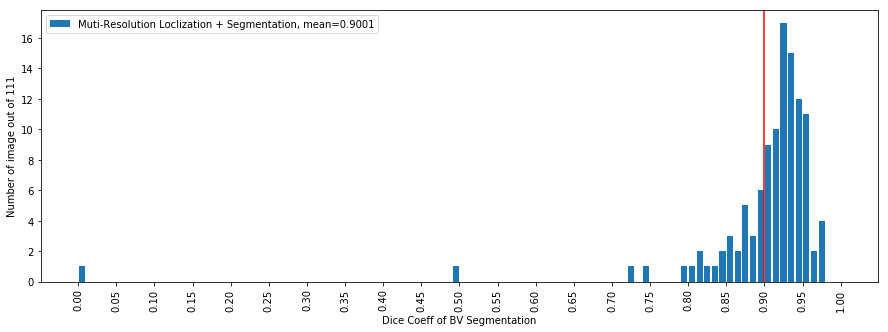

In [49]:
DSCdist = np.array(DSCdist)
plt.figure(figsize=(15,5))
plt.ylabel('Number of image out of 111')
plt.xlabel('Dice Coeff of BV Segmentation')
plt.hist(DSCdist, 100, range=(0,1), rwidth=0.8)
plt.legend(['Muti-Resolution Loclization + Segmentation, mean=0.9001'])
plt.axvline(x=0.9001, color='r')
plt.xticks(np.arange(0, 1.05, step=0.05), rotation=90)
plt.show()

In [12]:
check_seg(Locmodel, Segmodel, train_loader, device, dtype, 5.0)

259it [03:08,  1.52it/s]

0.8919051005736826


In [13]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 1, H, W, D)
    - y: Labels for X; LongTensor of shape (N,), actuually one label corresponds to one outout unit. in your case,
    just try to choose one of the unit from x,y,z centroid
    
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W, D) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    ##############################################################################
    # Perform a forward and backward pass through the model to compute the gradient 
    # of the correct class score with respect to each input image. You first want 
    # to compute the loss over the correct scores (we'll combine losses across a batch
    # by summing), and then compute the gradients with a backward pass.
    ##############################################################################
    scores = model(X)
    
    # Get the correct class computed scores.
    scores = scores.gather(1, y.view(-1, 1)).squeeze()  
    
    # Backward pass, need to supply initial gradients of same tensor shape as scores.
    scores.backward(torch.tensor(10.0).cuda(device))
    
    # Get gradient for image.
    saliency = X.grad.data
    
    saliency = saliency.abs()
    saliency = saliency.squeeze()
    ##############################################################################
    return saliency